<a href="https://colab.research.google.com/github/naoroha/Final-Project-Deep-Learning/blob/main/DeepLearningFInalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#final project
we will start with extracting the data and modify it

In [26]:
import pandas as pd
import requests
from pathlib import Path

# URL to download the Excel file from GitHub
url = "https://github.com/naoroha/Final-Project-Deep-Learning/raw/main/FM_dataset.xlsx"

# Check if the file exists
if not Path("FM_dataset.xlsx").is_file():
    # Download the file from GitHub
    response = requests.get(url)

    # Check if the download was successful
    if response.status_code == 200:
        # Save the file
        with open("FM_dataset.xlsx", "wb") as f:
            f.write(response.content)
    else:
        print("Failed to download the file")

# Read the Excel file into a DataFrame
df = pd.read_excel("FM_dataset.xlsx", sheet_name="design", engine="openpyxl")


In [27]:
#get some of the noises out
df=df[~df['sample'].str.contains('Fam')].reset_index(drop=True)
df=df[~df['sample'].str.contains('House')].reset_index(drop=True)
print(df['sample'])

0       Pt_Ctrl_101
1       Pt_Ctrl_117
2       Pt_Ctrl_155
3       Pt_Ctrl_156
4       Pt_Ctrl_188
           ...     
120    Pt_Fibro_934
121    Pt_Fibro_936
122    Pt_Fibro_946
123    Pt_Fibro_962
124    Pt_Fibro_989
Name: sample, Length: 125, dtype: object


In [28]:
X=df.drop(columns=['diagnosis','sample','gender',])
y=df['diagnosis']

##Turn data into tensors and create a train and test split

In [29]:
import torch

In [30]:
X_numpy = X.values
y_numpy = y.values
# Convert numpy array to PyTorch tensor
X = torch.tensor(X_numpy, dtype=torch.float)
y = torch.tensor(y_numpy, dtype=torch.float)

In [31]:
X_tensor_normalized = torch.nan_to_num(X, nan=0.0)

# Normalize the tensor
X_mean = X_tensor_normalized.mean(dim=0)
X_std = X_tensor_normalized.std(dim=0)
X= (X_tensor_normalized - X_mean) / X_std

In [32]:
# We will now split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

len(X_train),len(X_test),len(y_train),len(y_test)

(100, 25, 100, 25)

## building a model

building a model to classify our blue and red dots

we want to:
1. Setup device agonistic code so our code will run on an accelerator(GPU) if there is one not really necessary here, but good practice

2. Construct a model(subclassing nn.Module)
3. Define a loss function and optimizer
4. Create a training and testing loop

In [33]:
import torch
from torch import nn

#Make device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses '`nn.Module`'(almost all models in pyTorch subclass `nn.module`)
2. We will start with 2`nn.Linear()` layers that are capable of handeling the shapes of our data
3. Defines a `forward()` method the outlines the forward pass(or forward computation) of the model
4. Instatiate an intance of our model class and sent it to terget `device`



In [34]:
# in oreder to decide the "in_features" in our first layer we need to know our features shape
X_train.shape

torch.Size([100, 67])

In [17]:
# construct a model that subclasses nn.module, **Version 0**
class FibromyalgiaV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=67, out_features=12) # takes a full cordinate of 'X_train' and downscales it to 12 features
    self.layer_2 = nn.Linear(in_features=12, out_features=1) # takes the previous out 12 features and turns it to the expected output
  def forward(self,x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

model_0 = FibromyalgiaV0().to(device)
model_0

FibromyalgiaV0(
  (layer_1): Linear(in_features=67, out_features=12, bias=True)
  (layer_2): Linear(in_features=12, out_features=1, bias=True)
)

In [18]:
# Make predictions
with torch.inference_mode():
  untrained_preds= model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\n First 10 predictions:\n {untrained_preds[:10]} ")
print(f"\n First 10 labels:\n {y_test[:10]} ")

Length of predictions: 25, Shape: torch.Size([25, 1])
Length of test samples: 25, Shape: torch.Size([25])

 First 10 predictions:
 tensor([[ 0.3831],
        [-0.1443],
        [ 0.1285],
        [ 0.3847],
        [ 0.0760],
        [ 0.4754],
        [ 0.1574],
        [-0.0227],
        [ 0.2248],
        [ 0.4079]], device='cuda:0') 

 First 10 labels:
 tensor([0., 0., 0., 1., 1., 1., 1., 1., 1., 0.]) 


In [19]:
# Setup the loss function, the mission is to classification, so we will might want to use cross-enropy
loss_fn= nn.BCEWithLogitsLoss() # BCEWithLogitLoss = sgmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [20]:
#Calaculate accuracy
def accuarcy_fn(y_true,y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred)) *100
  return acc

## Train model

1. Forward pass
2. Calculate the loss
3. optimizer zero grad
4. Loss backwards (backpropagation)
5. Optimizer step (gardient descent)

### 1. Going from raw logits -> prediction probablities -> prediction labelss

our model outputs are going to be raw **logits**.

we can conveert these **logits** into **prediction propabilities** by passing them to some kind of activation function(e.g. sigmoid for binary classification and softmax for multiclass classification).
Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [21]:
# view the first 5 outpurs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits=model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.3831],
        [-0.1443],
        [ 0.1285],
        [ 0.3847],
        [ 0.0760]], device='cuda:0')

In [22]:
# use the sigmoid activation function on our model logits in order to turn them to propabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5946],
        [0.4640],
        [0.5321],
        [0.5950],
        [0.5190]], device='cuda:0')

In [23]:
# Find the predicted lebels
y_preds =torch.round(y_pred_probs)

# In Full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))

tensor([True, True, True, True, True], device='cuda:0')


# Building the training and test loop

In [24]:
# torch.manual_seed(42)

# # Set the number of epoches
# epoches = 100

# # put data to target device
# X_train,y_train = X_train.to(device), y_train.to(device)
# X_test, y_test = X_test.to(device), y_test.to(device)

# # Build training and evaluation loop
# for epoch in range(epoches):
#   ###Training
#   model_0.train()

#   # 1. Forward pass
#   y_logits = model_0(X_train).squeeze()
#   y_pred = torch.round(torch.sigmoid(y_logits)) # raw logits -> predoction propabilities -> prediction labels

#   #Calculate the loss
#   '''
#   nn.BCELoss insted of nn.BCEWithLogitsLoss
#     loss = loss_fn(torch.sigmoid(y_logits)
#                     ,y_train)
#   '''
#   train_loss = loss_fn(y_logits,
#                  y_train)
#   train_acc = accuarcy_fn(y_true=y_train,
#                     y_pred=y_pred)
#   # 3.Optimize zero grad
#   optimizer.zero_grad()

#   # 4. Loss backward
#   train_loss.backward()

#   # 5. Optimizer step
#   optimizer.step()

#   ###testing
#   model_0.eval()
#   with torch.inference_mode():
#     #1. Forward pass
#     test_logits = model_0(X_test).squeeze()
#     test_pred = torch.round(torch.sigmoid(test_logits))

#     #2. Calculate test loss and acc
#     test_loss= loss_fn(test_logits,
#                        y_test)
#     test_acc= accuarcy_fn(y_true=y_test,
#                           y_pred=test_pred)
#   if epoch % 10 == 0:
#     print(f"Epoch= {epoch} | Train_Loss = {train_loss:.5f} |  Train_Accuarcy = {train_acc:.2f} | Test_Loss = {test_loss:.5f} | Test_Accuracy = {test_acc:.2f}")


###assumption

from the metrics above we can see that the model really good, but we can not relay on that, we have to remember that the data is small

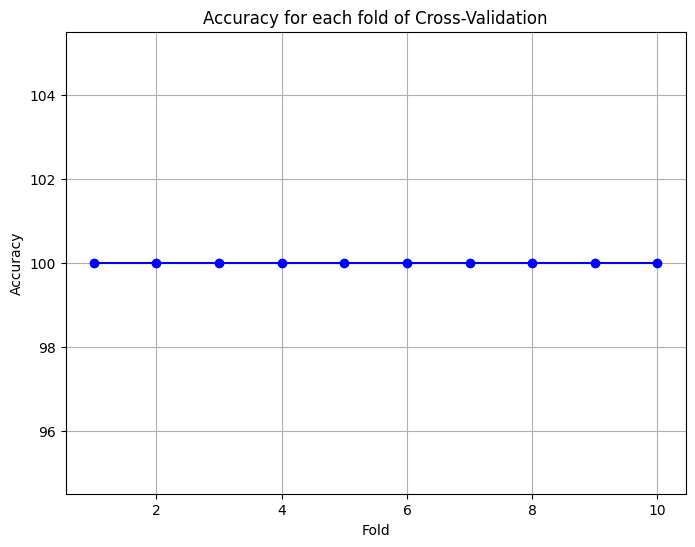

In [25]:
# We will now use the same model but in Cross-Validation approach
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np


torch.manual_seed(42)
# Define the number of folds for cross-validation
k = 10

# Initialize a KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)
epoches = 100

accuracy_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index].to(device), X[test_index].to(device)
    y_train, y_test = y[train_index].to(device), y[test_index].to(device)

    # Build training and evaluation loop
    for epoch in range(epoches):
      ###Training
      model_0.train()

      # 1. Forward pass
      y_logits = model_0(X_train).squeeze()
      y_pred = torch.round(torch.sigmoid(y_logits)) # raw logits -> predoction propabilities -> prediction labels

      #Calculate the loss
      '''
      nn.BCELoss insted of nn.BCEWithLogitsLoss
        loss = loss_fn(torch.sigmoid(y_logits)
                        ,y_train)
      '''
      train_loss = loss_fn(y_logits,
                    y_train)
      train_acc = accuarcy_fn(y_true=y_train,
                        y_pred=y_pred)
      # 3.Optimize zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      train_loss.backward()

      # 5. Optimizer step
      optimizer.step()

      ###testing
      model_0.eval()
      with torch.inference_mode():
        #1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        #2. Calculate test loss and acc
        test_loss= loss_fn(test_logits,
                          y_test)
        test_acc= accuarcy_fn(y_true=y_test,
                              y_pred=test_pred)
    accuracy_scores.append(test_acc)

# Plot the performance metric for each fold
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, k+1), accuracy_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy for each fold of Cross-Validation')
plt.grid(True)
plt.show()
